In [64]:
import sqlite3
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np


In [65]:
conn = sqlite3.connect("../../places.sqlite")

full_data = pd.read_sql_query(
    """
SELECT 
	moz_places.url as url,
    moz_historyvisits.'visit_date' as 'visit_date'
from moz_historyvisits
    join moz_places on moz_places.id = moz_historyvisits.place_id;
    
""",
    conn,
)

# conn = sqlite3.connect("../../history.sqlite")

# full_data = pd.read_sql_query(
#     """
# select
#   urls.url as url,
#   visits.visit_time as visit_date
# from
#   visits
#   join urls on urls.id = visits.url;

# """,
#     conn,
# )


In [66]:
full_data.head()


,url,visit_date
0,https://spins.fedoraproject.org/,1652190849558000
1,https://spins.fedoraproject.org/,1654098416035000
2,https://spins.fedoraproject.org/,1656856015277000
3,https://spins.fedoraproject.org/,1666263920924000
4,https://spins.fedoraproject.org/,1668600233996000


In [67]:
import csv
import re

full_data["host"] = full_data["url"].map(
    lambda x: re.match(r"https?:\/\/(([^/]+\.)+[^/]+)", x).group(1)
    if re.match(r"https?:\/\/(([^/]+\.)+[^/]+)", x) is not None
    else pd.NA
)


full_data.to_csv("full_data.csv", index=False, quoting=csv.QUOTE_ALL)
full_data["host"].isna().sum()


2229

In [68]:
from datetime import datetime

full_data["visit_date_obj"] = full_data["visit_date"].map(
    lambda x: datetime.fromtimestamp(x / 1000000)
)


In [69]:
full_data.drop("url", axis=1, inplace=True)
full_data["visit_count"] = 1

full_data.dropna(axis=0, how="any", inplace=True)
full_data.reset_index(inplace=True, drop=True)

full_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66210 entries, 0 to 66209
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   visit_date      66210 non-null  int64         
 1   host            66210 non-null  object        
 2   visit_date_obj  66210 non-null  datetime64[ns]
 3   visit_count     66210 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 2.0+ MB


In [70]:
full_data.head()


,visit_date,host,visit_date_obj,visit_count
0,1652190849558000,spins.fedoraproject.org,2022-05-10 13:54:09.558,1
1,1654098416035000,spins.fedoraproject.org,2022-06-01 15:46:56.035,1
2,1656856015277000,spins.fedoraproject.org,2022-07-03 13:46:55.277,1
3,1666263920924000,spins.fedoraproject.org,2022-10-20 11:05:20.924,1
4,1668600233996000,spins.fedoraproject.org,2022-11-16 12:03:53.996,1


In [10]:
time_frames = {
    "morning": (5, 11),
    "afternoon": (11, 17),
    "evening": (17, 23),
    # "night": (23, 5),
}

modified_data = pd.DataFrame()

modified_data["host"] = full_data["host"].unique()

for time_frame, (start, end) in time_frames.items():
    modified_data = modified_data.merge(
        full_data[
            (
                (full_data["visit_date_obj"].dt.hour >= start)
                & (full_data["visit_date_obj"].dt.hour < end)
            )
        ]
        .groupby("host")
        .agg({"visit_count": "sum"})
        .rename(columns={"visit_count": f"visits_{time_frame}"})
        .astype({f"visits_{time_frame}": pd.Int64Dtype()})
        .reset_index(),
        on="host",
        how="left",
    )

modified_data = modified_data.merge(
    full_data[
        (
            (full_data["visit_date_obj"].dt.hour < 5)
            | (full_data["visit_date_obj"].dt.hour <= 23)
        )
    ]
    .groupby("host")
    .agg({"visit_count": "sum"})
    .rename(columns={"visit_count": f"visits_night"})
    .astype({f"visits_night": pd.Int64Dtype()})
    .reset_index(),
    on="host",
    how="left",
)

modified_data["total_visits"] = modified_data[
    ["visits_morning", "visits_afternoon", "visits_evening", "visits_night"]
].sum(axis=1)

modified_data = modified_data.fillna(0)

modified_data.info()


AttributeError: Can only use .dt accessor with datetimelike values

In [ ]:
modified_data.head()


,host,visits_morning,visits_afternoon,visits_evening,visits_night,total_visits
0,spins.fedoraproject.org,4,10,0,14,28
1,www.redhat.com,37,75,2,117,231
2,www.wikipedia.org,2,2,1,5,10
3,www.mozilla.org,3,1,0,4,8
4,addons.mozilla.org,57,50,25,133,265


In [ ]:
selected_data = modified_data.sort_values(by="total_visits", ascending=False).iloc[:15]

# 'host',	'host_frecency',	'total_visits',	'visits_morning',	'visits_afternoon',	'visits_evening',	'visits_night'

# Melt the dataset to combine "visits_morning," "visits_afternoon," etc. into a "time" column
selected_data = selected_data.melt(
    id_vars=["host", "total_visits"],
    value_vars=["visits_morning", "visits_afternoon", "visits_evening", "visits_night"],
    var_name="visit_TOD",
    value_name="visit_count_TOD",
)

selected_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   host             60 non-null     object
 1   total_visits     60 non-null     int64 
 2   visit_TOD        60 non-null     object
 3   visit_count_TOD  60 non-null     Int64 
dtypes: Int64(1), int64(1), object(2)
memory usage: 2.1+ KB


/home/ubuntu/FDS/.venv/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


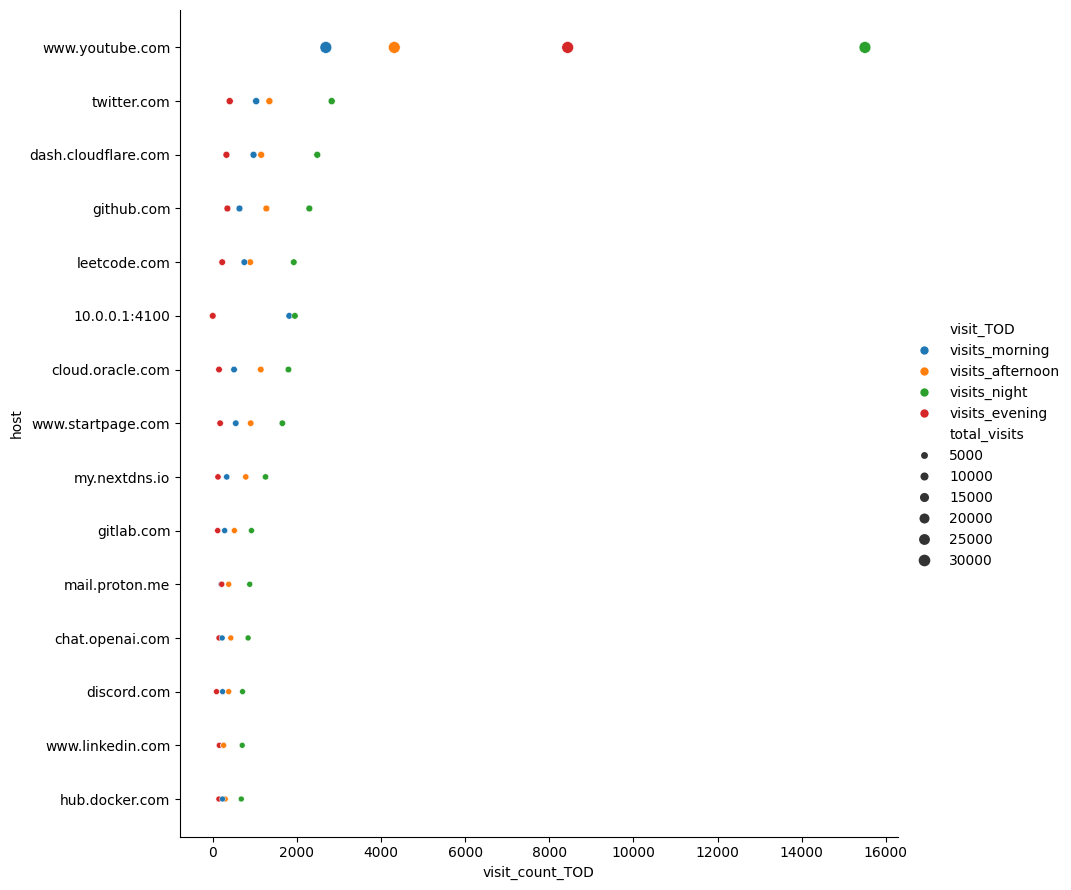

In [ ]:
ax = sns.relplot(
    x="visit_count_TOD",
    y="host",
    data=selected_data.sort_values(by="total_visits", ascending=False),
    hue="visit_TOD",
    size="total_visits",
    height=9,
    aspect=1.05,
    legend="brief",
)

# ax.set_xticklabels(rotation=90, ha="right", fontsize=8.5, y=1)

plt.show()
